In [0]:
# Install TensorFlow 2.0 for GPU
!pip uninstall -y -q tensorflow
!pip install -q tensorflow==2.0.0
!pip install -q gast==0.2.2
!pip install -q keract

import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
print(tf.__version__)

from google.colab import drive
drive.mount("/content/drive")

from __future__ import absolute_import, division, print_function, unicode_literals

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 46.8MB/s 
     |████████████████████████████████| 450kB 62.0MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
     |████████████████████████████████| 378kB 5.1MB/s 
2.0.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authoriz

In [0]:
# utilities.py
from tensorflow.python.framework import constant_op, dtypes, ops
from tensorflow.python.ops import array_ops, control_flow_ops, math_ops, nn, nn_ops
import os

import imageio
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib import pyplot
import ipywidgets
from ipywidgets import interact

base_path = "/content/drive/My Drive/Colab Notebooks/"
# contains *.tif, *_MRI.nii, *_LABEL.nii, *_GT.png files
path_training = base_path + "training/"
path_testing = base_path + "testing/"
path_groundtruth_training = base_path + "groundtruth-training/"
path_groundtruth_testing = base_path + "groundtruth-testing/"

# define parameters
batch_size = 1
epoch = 3
lr = 0.002
lamda = 1

In [0]:
@tf.function
def save_png(tensor, name):
    img = tf.cast(img, tf.uint8)
    img = tf.image.encode_png(img)
    tf.io.write_file('pred/' + name, img)
    return tensor

def show_volume(volume):
  show_information(volume)
  a = tf.transpose(volume,(2,0,1))
  def print_volume(x):
    plt.imshow(a[x], cmap='jet')
  interact(print_volume, x=ipywidgets.IntSlider(min=0, max=tf.shape(volume)[2]-1, step=1, value=0))

def show_information(x):
  tf.print("Tensor Shape:", tf.shape(x))
  tf.print("Shape:", x.shape)
  tf.print("Mean:", tf.reduce_mean(x))
  tf.print("Min:", tf.reduce_min(x))
  tf.print("Max:", tf.reduce_max(x))

@tf.function
def normalize_dataset(tensor):
    return tf.divide(
       tf.subtract(
          tensor,
          tf.reduce_min(tensor)
       ),
       tf.subtract(
          tf.reduce_max(tensor),
          tf.reduce_min(tensor)
       )
    )
  
@tf.function
def to_float_dataset(tensor):
    return tf.cast(tensor, tf.float32)

@tf.function
def zero_to_one_dataset(tensor):
    # int16 to float32, scaling from 0-32k to 0-1 is done automatically
   return tf.image.convert_image_dtype(tensor, tf.float32)

# loss function : 2 possibilities
# SSIM on prediction vs NSST groundtruth
# or SSIM on prediction vs each of the input slices
# y_true is the input volume
@tf.function
def loss_ssim_unsupervised(y_true, y_pred):
    #shape pred [1 240x 240y 1z]
    #shape true [1 240x 240y 155z]
    y_true = tf.transpose(y_true, perm=[3,1,2,0])
    y_pred = tf.squeeze(y_pred, 0)
    #reshape pred [240x 240y 1z]
    #reshape true [155z 240x 240y 1]

    def ssim_l1_loss(elems):
        ssim_layer_loss = lamda * (1 - tf.image.ssim(elems, y_pred, max_val = 1.0))
        l1_layer_loss = (1 - lamda) * (tf.reduce_mean(tf.abs(elems - y_pred)))
        return ssim_layer_loss + l1_layer_loss

    loss = tf.map_fn(ssim_l1_loss, y_true, dtype=tf.float32)
    # sum of all (l1 + ssim) layer losses = total loss
    return tf.reduce_sum(loss)
    
@tf.function
def loss_binary_crossentropy_unsupervised(y_true, y_pred):
    y_true = tf.transpose(y_true, perm=[3,1,2,0])
    y_pred = tf.squeeze(y_pred, 0)

    def binary_crossentropy_l1_loss(elems):
        binary_crossentropy_layer_loss = lamda * (1 - tf.keras.backend.binary_crossentropy(elems, y_pred))
        #l1_layer_loss = (1 - lamda) * (tf.reduce_mean(tf.abs(elems[0] - elems[1])))
        return binary_crossentropy_layer_loss # + l1_layer_loss

    loss = tf.map_fn(binary_crossentropy_l1_loss, y_true, dtype=tf.float32)
    # sum of all (l1 + ssim) layer losses = total loss
    return tf.reduce_sum(loss)

# SSIM on prediction vs groundtruth
# y_true is the NSST groundtruth
@tf.function
def loss_ssim_supervised_nsst(y_true, y_pred):
    # ssim and l1 loss : compare NSST groundtruth to the network's prediction
    ssim_mri_loss = lamda * (1 - tf.image.ssim(y_pred, y_true, max_val = 1.0))
    l1_mri_loss = (1 - lamda) * (tf.reduce_mean(tf.abs(y_pred - y_true)))
    return ssim_mri_loss + l1_mri_loss

In [0]:
print("PREPARING DATASET")
# load the training files from img folder : 3D MRI, 3D label mask
get_volume = lambda file: nib.load(file).get_data()
get_image = lambda file: pyplot.imread(file)

# 100 volumes, 100x240x240x155 voxels, values in 0-2^16/2, int16 array
train_volumes_mri = np.array(list(map(get_volume, glob.glob(path_training + "*_MRI.nii"))))
# 100 volumes, 100x240x240x155 voxels, values 0 or 1, uint8 array
train_volumes_label = np.array(list(map(get_volume, glob.glob(path_training + "*_LABEL.nii"))))
# 100 images, 100x240x240x1, values 0-2^16, uint16
train_images_groundtruth = np.array(list(map(get_image, glob.glob(path_groundtruth_training + "*.tif"))))
train_images_groundtruth = np.expand_dims(train_images_groundtruth, axis=-1) # empty dimension for channel
print("Found training dataset")

# implicit cast to float32 tensor, values in 0-1
# 3 options: normalize or divide by max integer value or cast to float
#train_volumes_mri = tf.map_fn(zero_to_one_dataset, train_volumes_mri, dtype=tf.float32)
train_volumes_mri = tf.map_fn(normalize_dataset, train_volumes_mri, dtype=tf.float32)
#train_volumes_mri = tf.map_fn(to_float_dataset, train_volumes_mri, dtype=tf.float32)
#train_images_groundtruth = tf.map_fn(zero_to_one_dataset, train_images_groundtruth, dtype=tf.float32)
train_images_groundtruth = tf.map_fn(normalize_dataset, train_images_groundtruth, dtype=tf.float32)
#train_images_groundtruth = tf.map_fn(to_float_dataset, train_images_groundtruth, dtype=tf.float32)
print("Normalized training dataset")

# mask dataset to remove all irrelevant data
# implicit cast label to bool tensor
train_volumes_mri_mask = tf.not_equal(train_volumes_label, 0)
# bool to 0 or 1
train_volumes_mri_mask = tf.cast(train_volumes_mri_mask, tf.float32)
# mask the MRI data with the label data, cast to int16 tensor
train_volumes_mri = tf.multiply(train_volumes_mri, train_volumes_mri_mask)
print("Masked training dataset")

test_volumes_mri = np.array(list(map(get_volume, glob.glob(path_testing + "*_MRI.nii"))))
test_volumes_label = np.array(list(map(get_volume, glob.glob(path_testing + "*_LABEL.nii"))))
test_images_groundtruth = np.array(list(map(get_image, glob.glob(path_groundtruth_testing + "*.tif"))))
test_images_groundtruth = np.expand_dims(test_images_groundtruth, axis=-1)
print("Found testing dataset")

# normalize the data
#test_images_groundtruth = tf.map_fn(zero_to_one_dataset, test_images_groundtruth, dtype=tf.float32)
test_images_groundtruth = tf.map_fn(normalize_dataset, test_images_groundtruth, dtype=tf.float32)
#test_images_groundtruth = tf.map_fn(to_float_dataset, test_images_groundtruth, dtype=tf.float32)
#test_volumes_mri = tf.map_fn(zero_to_one_dataset, test_volumes_mri, dtype=tf.float32)
test_volumes_mri = tf.map_fn(normalize_dataset, test_volumes_mri, dtype=tf.float32)
#test_volumes_mri = tf.map_fn(to_float_dataset, test_volumes_mri, dtype=tf.float32)
print("Normalized testing dataset")

# mask the MRI data with the label data
test_volumes_mri_mask = tf.not_equal(test_volumes_label, 0)
test_volumes_mri_mask = tf.cast(test_volumes_mri_mask, tf.float32)
test_volumes_mri = tf.multiply(test_volumes_mri, test_volumes_mri_mask)
print("Masked testing dataset")

In [0]:
# find the min and max coordinates where data can be found in a volume
def crop_size(arr):
  y, x = np.where(np.any(arr, 0))
  z, _ = np.where(np.any(arr, 1))
  minc = min(z),min(y),min(x)
  maxc = max(z)+1,max(y)+1,max(x)+1
  return minc,maxc # return cropped volume and coordinates

# crop the volume and groundtruth according to a given size
def crop(volume,size):
  (minc,maxc) = size
  return volume[minc[0]:maxc[0],minc[1]:maxc[1],minc[2]:maxc[2]]

# pad the cropped volumes and groundtruth to match the optimal size
def pad(volume,size):
  (minc,maxc) = size
  delta = np.subtract(opt, np.subtract(maxc, minc)) # optimal - current = how much padding should be added to the cropped volume
  delta = np.divmod(delta, 2)
  below = delta[0]; above = np.sum(delta, axis=0) # how much padding to add below and above
  return np.pad(volume,np.transpose((below,above)).astype(int), mode='constant', constant_values=0)

cropped_test_volumes_size = list(map(crop_size, test_volumes_mri))
cropped_test_volumes = list(map(crop, test_volumes_mri,cropped_test_volumes_size))
cropped_train_volumes_size = list(map(crop_size, train_volumes_mri))
cropped_train_volumes = list(map(crop, train_volumes_mri,cropped_train_volumes_size))

# get the delta between max and min
cropped_volume_optimal_size = list(map(lambda x: (x[1]-x[0]),
                               np.append(cropped_train_volumes_size, cropped_test_volumes_size, axis=0)))

opt = np.amax(cropped_volume_optimal_size,axis=0) # get the highest delta
opt = 2**np.ceil(np.log2(opt)) # pad to closest power of 2 for unet
optx,opty,optz = opt

cropped_padded_train_volumes_mri = list(map(pad,cropped_train_volumes,cropped_train_volumes_size))
cropped_padded_test_volumes_mri = list(map(pad,cropped_test_volumes,cropped_test_volumes_size))
cropped_padded_train_volumes_mri = tf.cast(cropped_padded_train_volumes_mri, tf.float32)
cropped_padded_test_volumes_mri = tf.cast(cropped_padded_test_volumes_mri, tf.float32)

#get size of cropped volume
print("Cropped dataset")

In [0]:
# 2D neural network :
# transform 240 x 240 x 155 volume into 240 x 240 x 1 plane through successive 2D convolutions with decreasing filters (155 -> 128 -> 64 -> 32 -> 16 -> 1)
# Initialize the weights based on truncated normal distribution with standard deviation of 0.01
# Bias of 0. No downsampling.
# Leaky ReLU activation to avoid banding

# layer 1
# input_shape = (samples, conv_dim1, conv_dim2, channels), with "channels" the depth of the volume
# output_shape = (samples, new_conv_dim1, new_conv_dim2, filters)
input = tf.keras.Input(shape=(240,240,155)) # 3D tensor with shape: (conv_dim1, conv_dim2, channels)
network = tf.keras.layers.Conv2D(
    filters = 128, # dimensionality of output space
    kernel_size = 5, # shape of 2D convolution window (5x5)
    strides = 1, # stride of convolution along all spatial dimensions
    padding = "same", data_format = "channels_last", # input with shape (batch, height, width, channels)
    activation = 'linear', # activation function to use
    use_bias = True,
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 1e-2), # initializer for the kernel weights matrix
    bias_initializer = 'zeros', # initializer for the bias vector
    input_shape = (240, 240, 155)
)(input)
network = tf.keras.layers.LeakyReLU(alpha = 0.2)(network)
network = tf.keras.layers.BatchNormalization(
    momentum = 0.1, # momentum + decay = 1.0
    epsilon = 1e-5,
    scale = True
)(network)
# layer 2
network = tf.keras.layers.Conv2D(
    filters = 64, # dimensionality of output space
    kernel_size = 5, # shape of 2D convolution window (5x5)
    strides = 1,
    padding = "same", data_format = "channels_last",
    activation = 'linear',
    use_bias = True,
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 1e-2),
    bias_initializer = 'zeros',
    input_shape = (240, 240, 128)
)(network)
network = tf.keras.layers.LeakyReLU(alpha = 0.2)(network)
network = tf.keras.layers.BatchNormalization(
    momentum = 0.1, # momentum + decay = 1.0
    epsilon = 1e-5
)(network)
# layer 3
network = tf.keras.layers.Conv2D(
    filters = 32, # dimensionality of output space
    kernel_size = 3, # shape of 2D convolution window (3x3)
    strides = 1,
    padding = "same", data_format = "channels_last",
    activation = 'linear',
    use_bias = True,
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 1e-2),
    bias_initializer = 'zeros',
    input_shape = (240, 240, 64)
)(network)
network = tf.keras.layers.LeakyReLU(alpha = 0.2)(network)
network = tf.keras.layers.BatchNormalization(
    momentum = 0.1, # momentum + decay = 1.0
    epsilon = 1e-5
)(network)
# layer 4
network = tf.keras.layers.Conv2D(
    filters = 16, # dimensionality of output space : 16 channels
    kernel_size = 3, # shape of 2D convolution window (3x3)
    strides = 1,
    padding = "same", data_format = "channels_last",
    activation = 'linear',
    use_bias = True,
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 1e-2),
    bias_initializer = 'zeros',
    input_shape = (240, 240, 32)
)(network)
network = tf.keras.layers.LeakyReLU(alpha = 0.2)(network)
network = tf.keras.layers.BatchNormalization(
    momentum = 0.1, # momentum + decay = 1.0
    epsilon = 1e-5
)(network)
# layer 5
network = tf.keras.layers.Conv2D(
    filters = 1, # dimensionality of output space : 1 channel (grayscale/flatten)
    kernel_size = 1, # shape of 2D convolution window (1x1)
    strides = 1,
    padding = "same", data_format = "channels_last",
    activation = 'linear', #tf.keras.activations.tanh,
    use_bias = True,
    kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev = 1e-2),
    bias_initializer = 'zeros',
)(network)
"""
# unet
input = Input(shape=(optx,opty,optz))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(input)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv9)
network = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv9)

# simplified unet
input = Input(shape=(optx,opty,optz)) # infer size at runtime from cropped volumes

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(input)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool4)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv5))
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(up6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv6))
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(up7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(UpSampling2D(size = (2,2))(conv7))
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(up8)
"""

"\n# unet\ninput = Input(shape=(optx,opty,optz))\nconv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(input)\nconv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv1)\npool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\nconv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool1)\nconv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv2)\npool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\nconv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(pool2)\nconv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format = 'channels_last')(conv3)\npool3 = MaxPooling2D(pool_size=(2, 2))(conv3)\nc

In [0]:
print("DEFINING MODEL")
model = tf.keras.Model(inputs = input, outputs = network)
#model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_binary_crossentropy_unsupervised, metrics = ['accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_ssim_unsupervised, metrics = ['accuracy'])
#model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_ssim_supervised_nsst, metrics = ['accuracy'])

checkpoint_path = base_path + "checkpoints/checkpoint-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
latest = tf.train.latest_checkpoint(base_path + "checkpoints")
if(latest == None):
    print("No checkpoints")
else:
    print("Loading latest checkpoint")
    #model.load_weights(latest)
model.summary(line_length=100)
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model_unet.png')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=base_path + 'logs')

DEFINING MODEL
Loading latest checkpoint
Model: "model_5"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_3 (InputLayer)                         [(None, 240, 240, 155)]                 0              
____________________________________________________________________________________________________
conv2d_28 (Conv2D)                           (None, 240, 240, 128)                   496128         
____________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)                    (None, 240, 240, 128)                   0              
____________________________________________________________________________________________________
batch_normalization_4 (BatchNormalization)   (None, 240, 240, 128)                   512            
_________________________________

In [0]:
print("STARTING TRAINING PHASE")
# train
history_fit = model.fit(cropped_padded_train_volumes_mri, cropped_padded_train_volumes_mri, epochs = epoch, batch_size = batch_size, callbacks = [cp_callback])
#history_fit = model.fit(train_volumes_mri, train_images_groundtruth, epochs = epoch, batch_size = batch_size, callbacks = [cp_callback, tb_callback])

STARTING TRAINING PHASE
Train on 5 samples
Epoch 1/3
4/5 [=======================>......] - ETA: 2s - loss: 13.4947 - accuracy: 0.9400
Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint-0001.ckpt
5/5 [==============================] - 13s 3s/sample - loss: 15.2135 - accuracy: 0.9308
Epoch 2/3
4/5 [=======================>......] - ETA: 1s - loss: 13.4946 - accuracy: 0.9400
Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint-0002.ckpt
5/5 [==============================] - 10s 2s/sample - loss: 15.2134 - accuracy: 0.9308
Epoch 3/3
4/5 [=======================>......] - ETA: 1s - loss: 15.0204 - accuracy: 0.9306
Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/checkpoints/checkpoint-0003.ckpt
5/5 [==============================] - 9s 2s/sample - loss: 15.2134 - accuracy: 0.9308


In [0]:
print("STARTING TESTING PHASE")
show_information(test_volumes_mri)
history_eval = model.evaluate(cropped_padded_test_volumes_mri, cropped_padded_test_volumes_mri, batch_size = batch_size)
#history_eval = model.evaluate(test_volumes_mri, test_images_groundtruth, batch_size = batch_size)

# get results
predictions = model.predict(cropped_padded_test_volumes_mri, batch_size = 1, verbose = 1)
print("max pixel value:", tf.reduce_max(predictions))

STARTING TESTING PHASE
Tensor Shape: [2 240 240 155]
Shape: TensorShape([2, 240, 240, 155])
Mean: 0.00362583483
Min: 0
Max: 0.933266938
2/1 [============================================================] - 0s 199ms/sample
max pixel value: tf.Tensor(0.0, shape=(), dtype=float32)


In [0]:
tf.print("predictions")
show_information(predictions)
tf.print("\ntrain-groundtruth")
show_information(train_images_groundtruth)
tf.print("\ntest-groundtruth")
show_information(test_images_groundtruth)
tf.print("\ntrain-dataset")
show_information(train_volumes_mri)
tf.print("\ntest-dataset")
show_information(test_volumes_mri)

predictions
Tensor Shape: [2 128 128 1]
Shape: (2, 128, 128, 1)
Mean: 0
Min: 0
Max: 0

train-groundtruth
Tensor Shape: [100 240 240 1]
Shape: TensorShape([100, 240, 240, 1])
Mean: 0.0122436183
Min: 0
Max: 1

test-groundtruth
Tensor Shape: [2 240 240 1]
Shape: TensorShape([2, 240, 240, 1])
Mean: 0.00887712091
Min: 0
Max: 1

train-dataset
Tensor Shape: [5 240 240 155]
Shape: TensorShape([5, 240, 240, 155])
Mean: 0.00534980558
Min: 0
Max: 0.775265932

test-dataset
Tensor Shape: [2 240 240 155]
Shape: TensorShape([2, 240, 240, 155])
Mean: 0.00362583483
Min: 0
Max: 0.933266938


In [0]:
show_volume(test_volumes_mri[1])

Tensor Shape: [240 240 155]
Shape: TensorShape([240, 240, 155])
Mean: 0.00551973283
Min: 0
Max: 0.933266938


interactive(children=(IntSlider(value=0, description='x', max=154), Output()), _dom_classes=('widget-interact'…

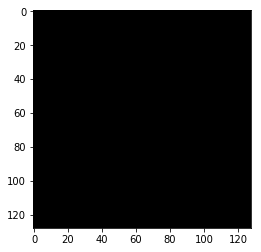

In [0]:
i=0
for pred in predictions:
    img = tf.image.convert_image_dtype(pred, tf.uint8)
    plt.imshow(tf.tile(img, (1,1,3)))
    img = tf.image.encode_png(img)
    name = base_path + 'pred/linear_lr0.002-normalize-cropped-ssim_unsupervised' + str(i) + '.png'
    tf.io.write_file(name, img)
    i = i + 1

In [0]:
from keract import get_activations,display_activations,display_heatmaps,get_gradients_of_trainable_weights,get_gradients_of_activations

input_image=cropped_padded_test_volumes_mri[0]
input_image = np.expand_dims(input_image, axis=-1)
activations = get_activations(model, input_image)
display_activations(activations, cmap="gray", save=True)
display_heatmaps(activations, input_image, save=True)
get_gradients_of_trainable_weights(model, input_image, images_groundtruth)
get_gradients_of_activations(model, input_image, images_groundtruth)

ValueError: ignored